
## Introduction

__Quantum walks__, the quantum analogs of classical random walks, play a crucial role in the advancement of quantum computing and quantum information science [1]. These walks, governed by the principles of quantum mechanics, exhibit distinct behaviors from their classical counterparts due to superposition and interference effects, which enable more efficient exploration of state spaces [4].

In contrast to classical random walks, which spread diffusively with time, quantum walks demonstrate ballistic propagation with interference patterns that arise from the constructive and destructive combination of quantum probability amplitudes [1]. These unique properties have positioned quantum walks as a powerful tool in the development of quantum algorithms, particularly in search algorithms, graph traversal, and quantum simulation [4].

The __continuous-time quantum walk__ (CTQW), which evolves under the Schrödinger equation, represents a natural generalization of the classical walk in continuous time [1]. The Hamiltonian of the system governs the unitary evolution of the quantum state [3]. This study focuses on simulating a CTQW on a two-dimensional grid using Qiskit, a quantum programming framework.

Through this simulation, we aim to illustrate the key phenomena that distinguish quantum walks from classical ones, such as their non-classical probability distributions and ballistic transport behavior. Specifically, we investigate the quantum walker's evolution on a $7\times7$ grid (the dimensions are easily adaptable to produce more insightful results for the propagation), providing both theoretical underpinnings and computational implementations to gain deeper insights into quantum transport phenomena. This work serves as a foundational investigation for understanding the dynamics of quantum walks and their potential in quantum computing applications.


In [93]:
# 0. Importing Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import AerSimulator
from scipy.linalg import expm


### 0. **Importing Required Libraries**

   We begin by importing the necessary Python libraries for constructing, simulating, and visualizing the quantum walk on a two-dimensional grid.

- __numpy__ is utilized for numerical operations, particularly for managing arrays and linear algebra.
- __matplotlib.pyplot__ is tailored to data visualization purposes, allowing us to display the results of the quantum walk as heatmaps and graphs.
- __networkx__ is employed to create and manipulate the 2D grid graph.
- __qiskit__ is the quantum computing framework that provides the tools to construct and simulate quantum circuits.
- __scipy.linalg.expm__ computes the matrix exponential, crucial for simulating the time evolution of the quantum walk.


In [94]:
# 1. Define Parameters
grid_size = (7, 7)  # Square grid dimensions, easily adaptable to produce more insightful results for the propagation
times = np.linspace(0.5, 5.0, 10)  # Time steps 
shots = 8192  # Number of shots for simulation
initial_node = (grid_size[0] // 2, grid_size[1] // 2)  # Center of the grid


### 1. **Defining Parameters**

This section defines the parameters used in the quantum walk simulation [1]:

- The **grid size** is set to $7 \times 7$, which defines the number of vertices (positions) available to the walker [4].
- The **time steps** are represented by a NumPy array, $t \in [0.5, 5.0]$, with 10 evenly spaced values. This array is used to simulate the walker's evolution at discrete intervals [1].
- The **number of shots**, $8192$, refers to the number of repetitions of the simulation to gather sufficient statistical data [5].
- The **initial node** is set to the center of the grid, $(3,3)$, meaning that the quantum walker begins the walk localized in this central position [4].


In [95]:
# 2. Construct the Grid Graph
def create_grid_graph(grid_size):
    """Create a 2D grid graph of specified size."""
    G = nx.grid_2d_graph(*grid_size)
    pos = dict((n, n) for n in G.nodes())
    return G, pos

G, pos = create_grid_graph(grid_size)

### 2. **Constructing the Grid Graph**

The function constructs a **2D grid graph** $G = (V, E)$, where:

- $V$ represents the set of vertices (nodes) corresponding to grid points.
- $E$ represents the set of edges connecting adjacent vertices (grid points).

The position of each vertex is recorded using a dictionary `pos`, where each key corresponds to a vertex and its value is its respective position in the 2D grid.

#### Mathematical Representation:
The graph is constructed using **NetworkX** as a **Cartesian product** of two path graphs $P_7 \times P_7$, creating a 2D grid of size $7 \times 7$ with **49 nodes**.


In [96]:
# 3. Prepare the Quantum Walk Simulation
def get_hamiltonian(G):
    """Construct the Hamiltonian from the adjacency matrix."""
    A = nx.adjacency_matrix(G).todense()
    H = np.array(A, dtype=complex)
    return H

### 3. **Hamiltonian Construction**

The Hamiltonian $\mathcal{H}$ is derived from the adjacency matrix $A$ of the grid graph [1]:

$$
\mathcal{H} = A
$$

Where:
- $A$ is a **49 x 49** adjacency matrix derived from the grid graph $G$ [4].
- Each entry $A_{ij} = 1$ indicates a connection (edge) between nodes $i$ and $j$, and $A_{ij} = 0$ otherwise [4].

This Hamiltonian governs the **time evolution** of the quantum state according to the **Schrödinger equation** [5]:

$$
i\hbar \frac{d}{dt} |\psi(t)\rangle = \mathcal{H} |\psi(t)\rangle
$$

For this simulation, $\hbar = 1$, simplifying the equation to [5]:

$$
\frac{d}{dt} |\psi(t)\rangle = -i \mathcal{H} |\psi(t)\rangle
$$


In [97]:
H = get_hamiltonian(G)
N = H.shape[0]  # Number of nodes

In this simulation, the Hamiltonian directly corresponds to the graph's adjacency matrix, which encodes the connectivity between nodes. The resulting matrix $\mathcal{H}$ has dimensions $N \times N$, where $N$ is the number of nodes in the graph.

In [98]:
# 4. Number of qubits required
num_qubits = int(np.ceil(np.log2(N)))  

### 4. **Number of Qubits Calculation**

In quantum computing, the number of qubits required to represent a system is determined by the dimension of the system’s state space. Since the system we are modeling has $N$ nodes, we have to take into account a state space of dimension $N$ [5]. The number of qubits $n$ required to represent this state space is given by [5]:

$$
n = \lceil \log_2(N) \rceil
$$

Where:
- $N$ is the number of nodes (grid points) in the system [4].
- $ \log_2(N)$ gives the number of qubits needed to represent the state space of the quantum system [5].
- $\lceil \cdot \rceil$ denotes the ceiling function, which ensures that we round up to the nearest whole number, as qubits can only represent powers of 2 states [5].


In [99]:
# 5. Node-to-Index Mappings 
def get_node_mappings(G):
    """Create mappings between nodes and indices."""
    node_list = list(G.nodes())
    node_to_index = {node: i for i, node in enumerate(node_list)}
    index_to_node = {i: node for node, i in node_to_index.items()}
    return node_to_index, index_to_node

node_to_index, index_to_node = get_node_mappings(G)


### 5. **Node-to-Index Mappings**

To translate between the grid nodes and the computational basis states of the quantum system, we create two mappings [4]:

1. **Node-to-index mapping**: This maps each node in the graph to a unique integer index, corresponding to a computational basis state in the quantum circuit [5].
2. **Index-to-node mapping**: The reverse mapping, which translates a computational basis state back to its corresponding graph node [5].

These mappings make sure that the quantum circuit can correctly interpret the grid positions as quantum states and the other way round. [1].

Formally, let $V$ be the set of nodes in the graph. The node-to-index mapping is a bijective function $f : V \rightarrow \{0, 1, \dots, N-1\}$, while the index-to-node mapping is its inverse $f^{-1} : \{0, 1, \dots, N-1\} \rightarrow V$ [5].


In [100]:
# 6. Preparation of Initial States
def prepare_initial_state(initial_node, node_to_index, num_qubits):
    """Prepare the initial state vector for the quantum walk."""
    initial_index = node_to_index[initial_node]
    initial_state = np.zeros(2**num_qubits, dtype=complex)
    initial_state[initial_index] = 1.0  # Start at the initial node
    return initial_state

initial_state = prepare_initial_state(initial_node, node_to_index, num_qubits)

### 6. **Preparation of Initial States**

The initial state of the quantum walker is prepared as a **computational basis vector**, where the walker starts in a localized state at a specific node on the grid [4]. In this case, the walker begins at the **initial node** defined by its position on the grid.

The initial state vector $|\psi(0)\rangle$ is represented in a $2^n$-dimensional Hilbert space (where $n$ is the number of qubits) [5]. The vector is initialized such that only the component corresponding to the initial node's index is set to 1, with all other components set to 0.

Let the initial node be $\text{node}_0$, and let $f(\text{node}_0) = i_0$ be the index corresponding to this node. The initial state $|\psi(0)\rangle$ is given by:

$$
|\psi(0)\rangle = (0, 0, \dots, 1_{i_0}, \dots, 0)^\top
$$

This mathematical expression represents the walker being solely localized at the starting node $\text{node}_0$ [4].


In [101]:
# 7. Simulate the Quantum Walk
def simulate_quantum_walk(H, times, initial_state, num_qubits, N, node_to_index, index_to_node, shots):
    """Simulate the quantum walk at different times."""
    simulator = AerSimulator()
    probability_distributions = []

    for t in times:
        # Compute the unitary operator U = exp(-i H t)
        U = expm(-1j * H * t)

        # Pad U to size 2^num_qubits x 2^num_qubits with identity matrix
        dim = 2**num_qubits
        if dim > N:
            U_padded = np.eye(dim, dtype=complex)
            U_padded[:N, :N] = U
        else:
            U_padded = U

        # Create a UnitaryGate
        unitary_gate = UnitaryGate(U_padded)

        # Build the quantum circuit
        qc = QuantumCircuit(num_qubits, num_qubits)

        # Initialize the circuit with the initial state
        qc.initialize(initial_state, qc.qubits)

        # Apply the unitary operator
        qc.append(unitary_gate, qc.qubits)

        # Measure the qubits
        qc.measure(range(num_qubits), range(num_qubits))

        # Transpile and simulate the circuit
        qc_compiled = transpile(qc, simulator)
        result = simulator.run(qc_compiled, shots=shots).result()
        counts = result.get_counts()

        # Map measurement results to vertex indices
        node_probabilities = {}

        for bitstring, count in counts.items():
            index = int(bitstring, 2)
            if index < N:
                node = index_to_node[index]
                node_probabilities[node] = node_probabilities.get(node, 0) + count

        # Normalize probabilities
        for node in node_probabilities:
            node_probabilities[node] /= shots

        probability_distributions.append((t, node_probabilities))

    return probability_distributions

probability_distributions = simulate_quantum_walk(
    H, times, initial_state, num_qubits, N, node_to_index, index_to_node, shots
)

### 7. Simulating the Quantum Walk

The simulation of the quantum walk evolves the initial quantum state over time, governed by the **Hamiltonian** $\mathcal{H}$ [1], [3]. The evolution of the quantum state is computed for various time steps $t$, and the results of the walk are measured to generate the corresponding probability distributions over the grid's nodes [1].

#### 7.1. Time Evolution and Unitary Operator

For each time step $t$, the **unitary time evolution operator** $U(t)$ is computed using the following relation [5]:

$$
U(t) = e^{-i\mathcal{H}t}
$$

Where:
- $\mathcal{H}$ is the Hamiltonian governing the system's dynamics [1].
- $t$ is the current time step.
- $e^{-i\mathcal{H}t}$ is the matrix exponential of $-i\mathcal{H}t$, which dictates how the quantum state evolves over time [5].

This unitary operator is then used to propagate the initial state $ |\psi(0)\rangle $ to the state at time $ t $, $ |\psi(t)\rangle $, according to:

$$
|\psi(t)\rangle = U(t) |\psi(0)\rangle
$$

#### 7.2. Matrix Padding

The size of the unitary matrix $U(t)$ needs to match the qubit space dimension, which is $2^{\text{num\_qubits}}$. If the dimension of the Hamiltonian $N$ (i.e., the number of nodes) is smaller than the qubit space, the unitary matrix $U(t)$ is padded with an identity matrix to ensure compatibility [5]:

- Let $\text{dim} = 2^{\text{num\_qubits}}$, which is the dimension of the qubit space [5].
- If $\text{dim} > $N$, pad $U(t)$ with an identity matrix:

$$
U_{\text{padded}}(t) = \begin{bmatrix}
U(t) & 0 \\
0 & I_{\text{dim} - N}
\end{bmatrix}
$$

Where $I_{\text{dim} - N}$ is the identity matrix of size $\text{dim} - N$ [5].

#### 7.3. Quantum Circuit Construction

Once the unitary operator $U(t)$ is computed and padded (if necessary), the quantum circuit is constructed [5]:

- The circuit is initialized with the **initial state** $|\psi(0)\rangle$ [5].
- The **unitary operator** is applied to evolve the state $|\psi(0)\rangle$ to $|\psi(t)\rangle$ [5].
- Finally, the qubits are **measured** to retrieve the state of the system at time $t$ [5].

This process is repeated for each time step $t$ [1].

#### 7.4. Simulation of the Quantum Circuit

The quantum circuit is compiled and simulated using the **AerSimulator** backend [5]. The results of the simulation are obtained in the form of **counts**, which represent the measurement outcomes (bitstrings) of the qubits [5].

#### 7.5. Mapping Measurement Results to Nodes

The measurement results (bitstrings) are converted to the corresponding node indices. Each bitstring represents a binary number, which is mapped to an index. If the index is smaller than the total number of nodes $N$, it is mapped to the corresponding node on the grid [5].

#### 7.6. Probability Distribution Calculation

The counts from the measurements are normalized to generate the probability distribution over the grid nodes [5]. For each node, the probability is calculated as:

$$
P(\text{node}) = \frac{\text{count}}{\text{shots}}
$$

Where:
- $\text{count}$ is the number of times the bitstring corresponding to a specific node was measured [5].
- $\text{shots}$ is the total number of simulations run [5].

#### 7.7. Return of Results

The function returns the probability distributions for each time step $t$, where each distribution reflects the likelihood of the walker being found at various grid nodes at the respective time step [1], [3], [5].


In [102]:
# 8. Visualize the Results
def plot_heatmap(probabilities, grid_size, t):
    """Plot a heatmap of the probability distribution."""
    heatmap = np.zeros(grid_size)

    for (x, y), prob in probabilities.items():
        heatmap[y, x] = prob  # Note: y, x because of array indexing

    plt.figure(figsize=(8, 6))
    plt.imshow(heatmap, cmap='viridis', interpolation='nearest', origin='lower')
    plt.title(f'Quantum Walk on a {grid_size[0]}x{grid_size[1]} Grid after time t={t:.2f}')
    plt.colorbar(label='Probability')
    plt.xticks(range(grid_size[0]))
    plt.yticks(range(grid_size[1]))
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.show()

#### 8. Heatmap Visualization

The **heatmap** visualization provides a clear and intuitive representation of the quantum walker's probability distribution across the 2D grid. It uses color intensities to represent the likelihood of the walker being found at specific positions on the grid.

The function `plot_heatmap()` constructs the heatmap by iterating over the nodes' probability distributions and mapping them to the corresponding grid coordinates $(x, y)$. The heatmap uses a color gradient (here, `viridis`) to indicate the probability magnitude at each grid point. A **color bar** is also displayed, showing the relationship between the color intensity and the probability value.

The key steps involved in the heatmap visualization are:

- **Grid initialization**: A 2D array of zeros is created to represent the grid.
- **Population of probabilities**: For each node in the quantum walk, the corresponding probability is placed into the grid array based on its $(x, y)$ coordinates.
- **Visualization**: The `imshow()` function displays the populated grid as a heatmap, and a title and axes labels are added for clarity. The time step $t$ is also displayed in the title to indicate the quantum walk's evolution over time.


In [103]:
# 9. Graph-Based Visualization
def plot_graph(G, pos, probabilities, t):
    """Visualize the probability distribution on the graph."""
    plt.figure(figsize=(6, 6))
    node_sizes = [probabilities.get(node, 0) * 2000 for node in G.nodes()]
    nx.draw(G, pos=pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=node_sizes)
    plt.title(f'Quantum Walk Probability Distribution at time t={t:.2f}')
    plt.show()

#### 9. Graph-Based Visualization

In addition to the heatmap, a **graph-based visualization** provides a complementary view of the probability distribution. The grid graph used to model the quantum walk is displayed with **node sizes proportional** to the probability that the walker is located at that node.

The function `plot_graph()` constructs the graph visualization as follows:

- **Node size calculation**: The size of each node is determined by its corresponding probability value, scaled by a factor (here, 2000) to make the visualization clearer.
- **Graph rendering**: The `nx.draw()` function from **NetworkX** is used to render the graph, where:
  - The **positions** of the nodes are fixed to their grid coordinates.
  - Nodes with higher probabilities are displayed larger in size, visually emphasizing the walker's likelihood of being at specific positions.
  - The time step $t$ is displayed in the title to show the quantum walk's progression over time.


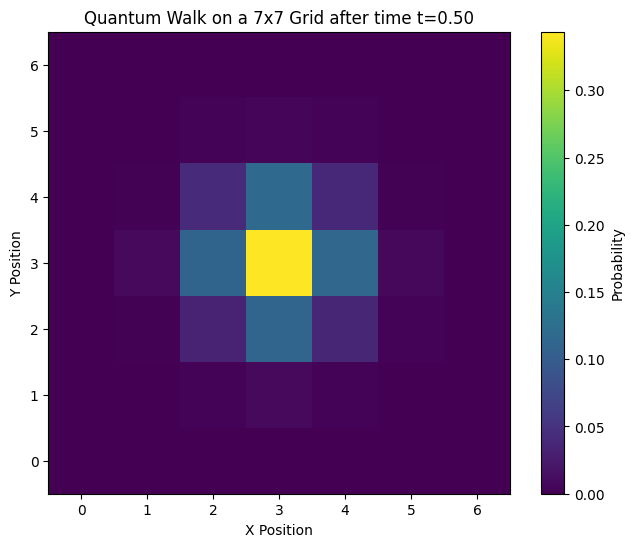

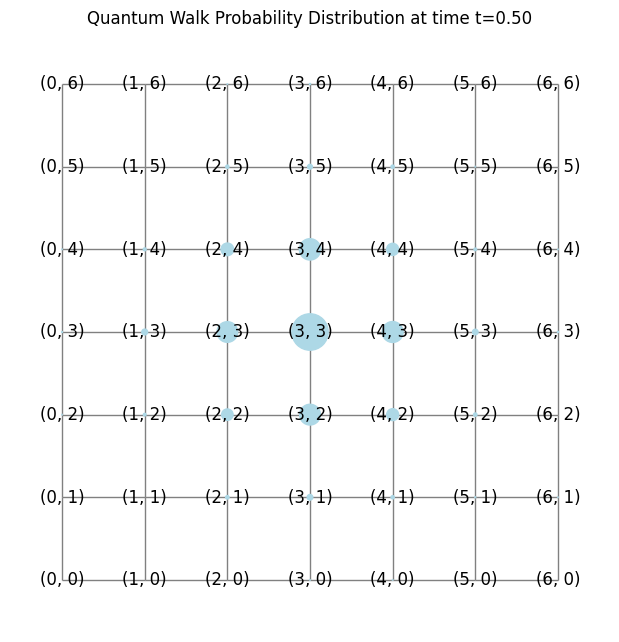

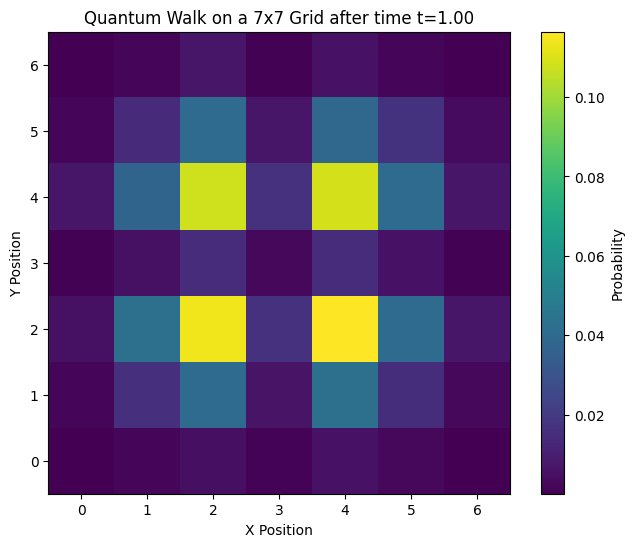

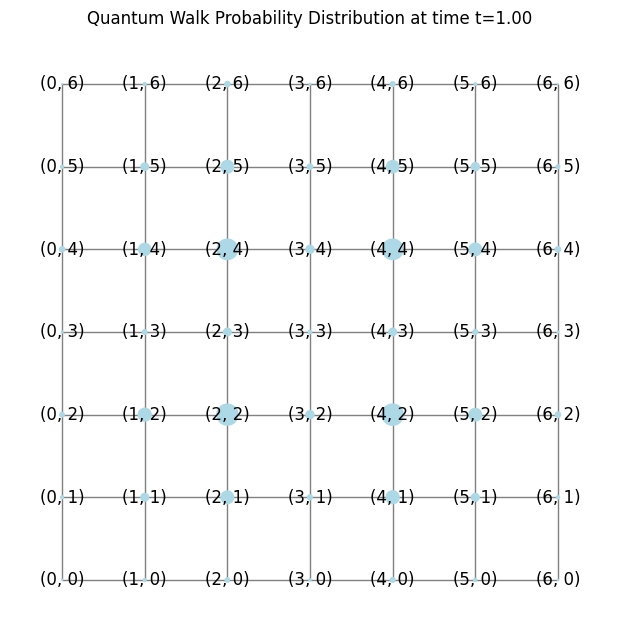

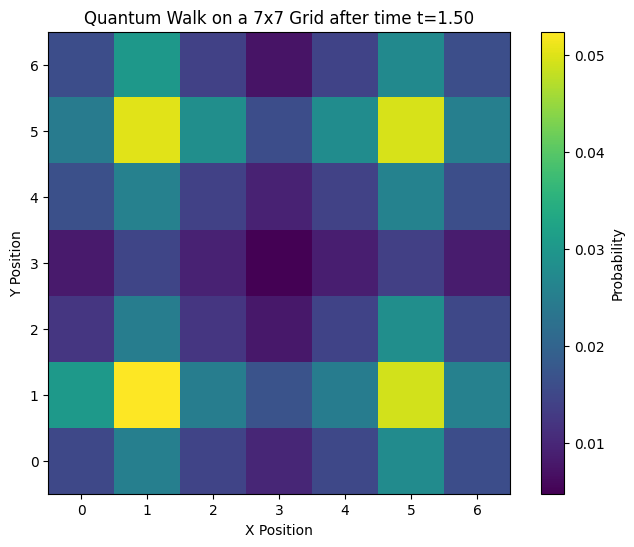

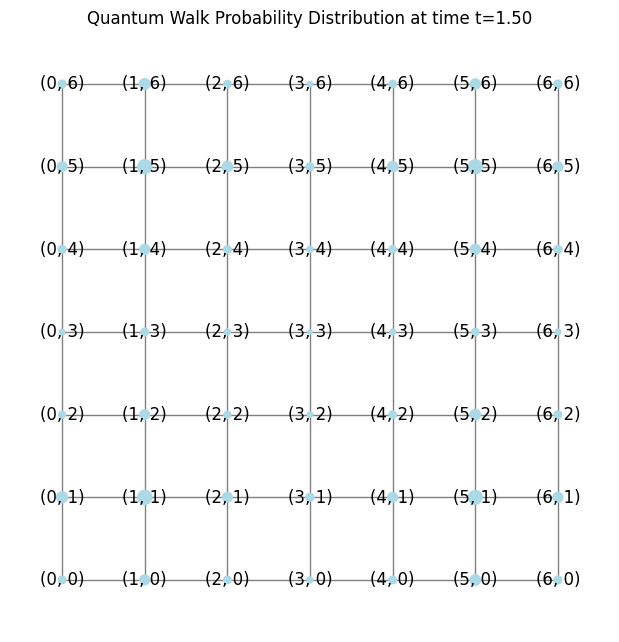

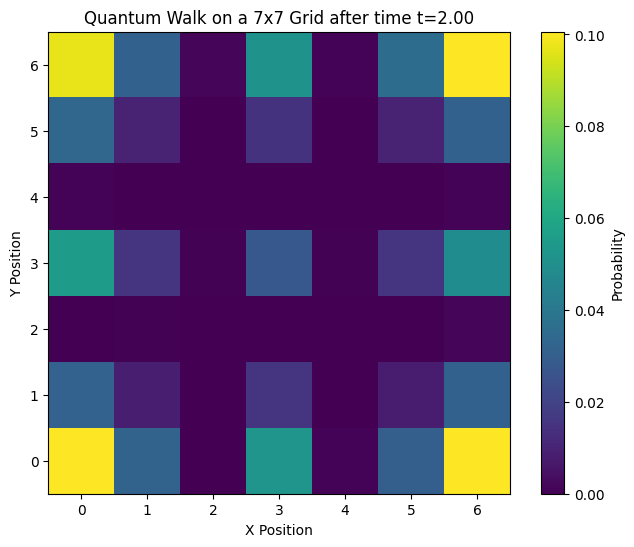

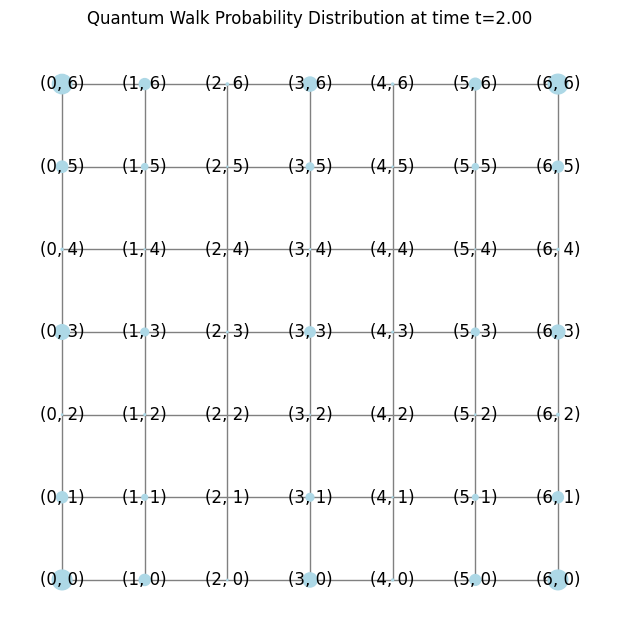

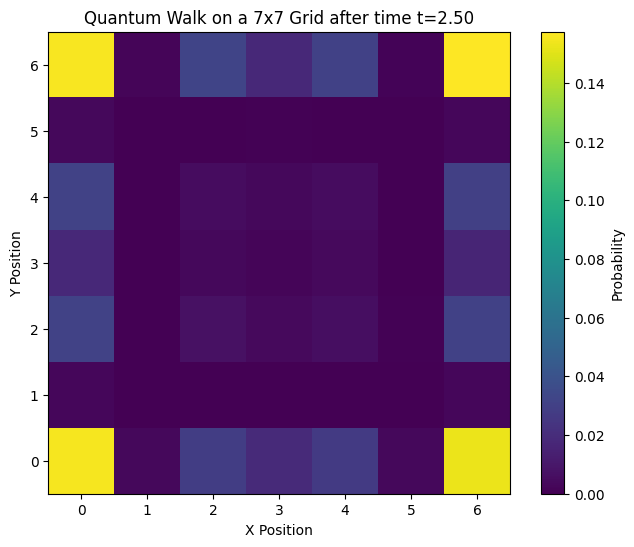

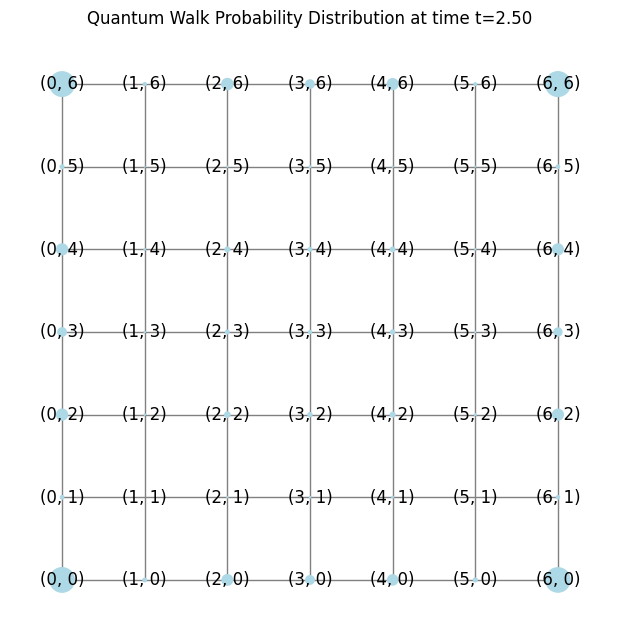

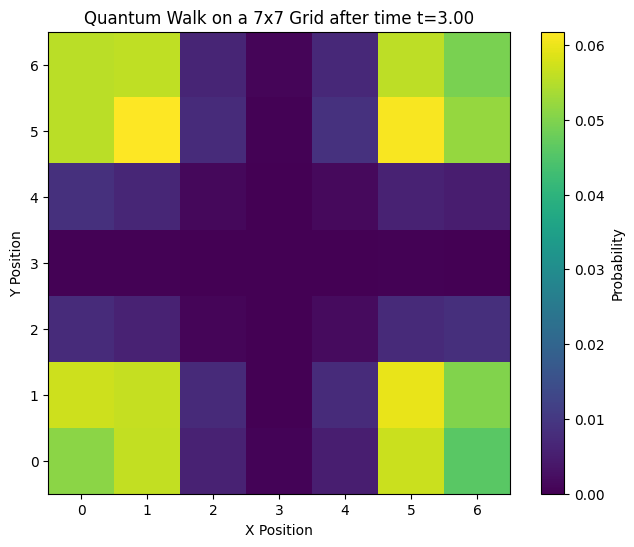

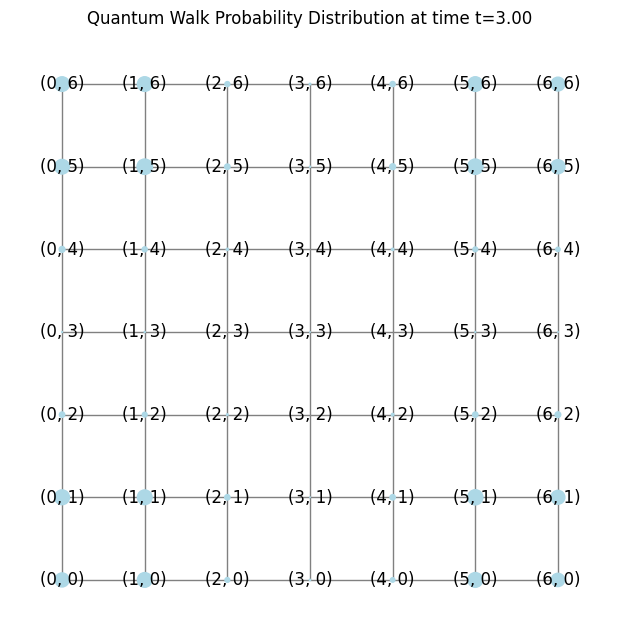

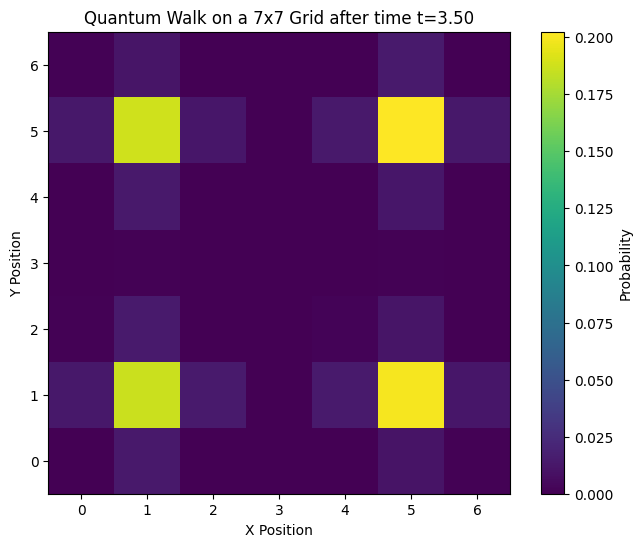

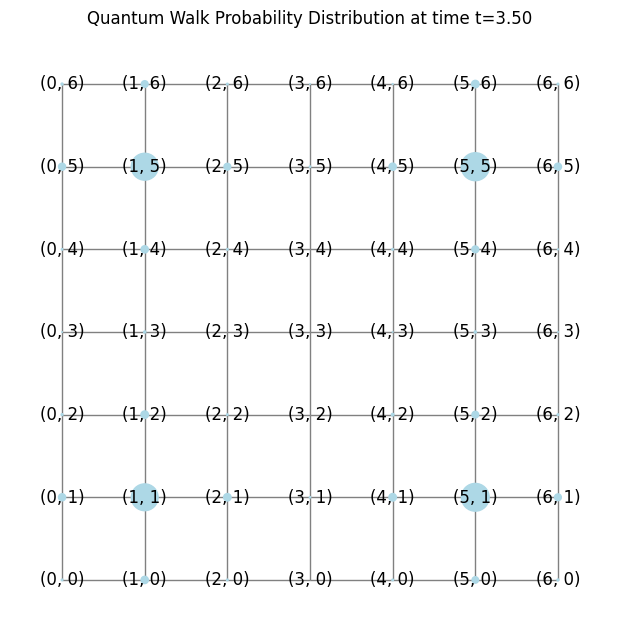

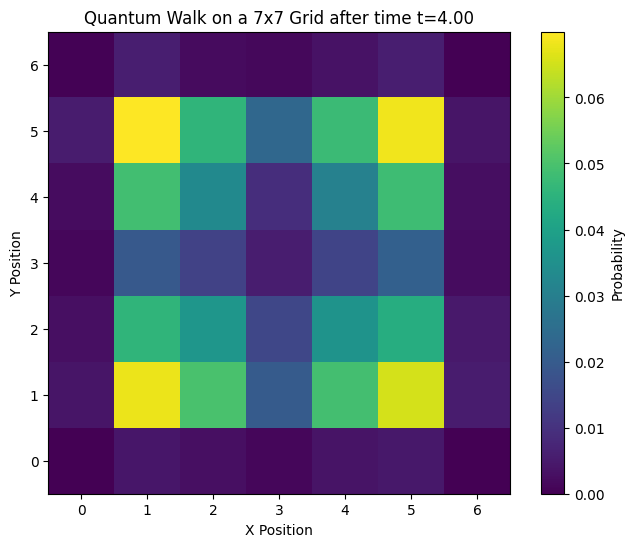

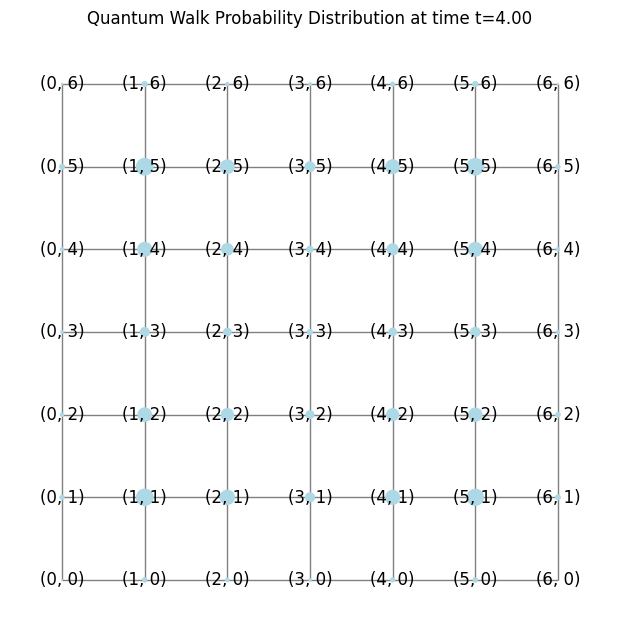

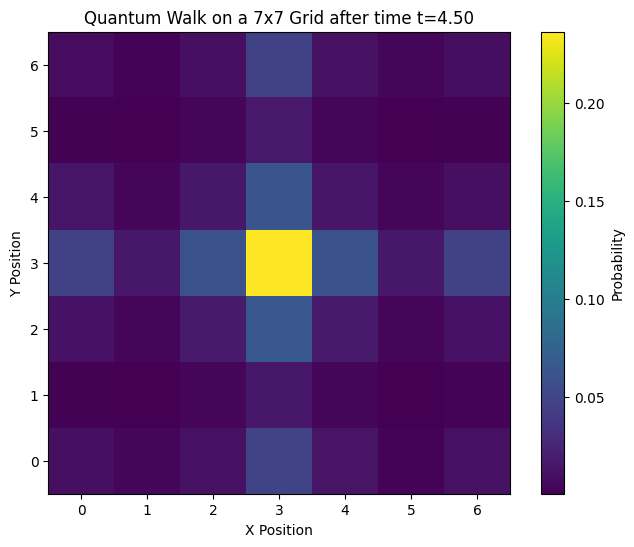

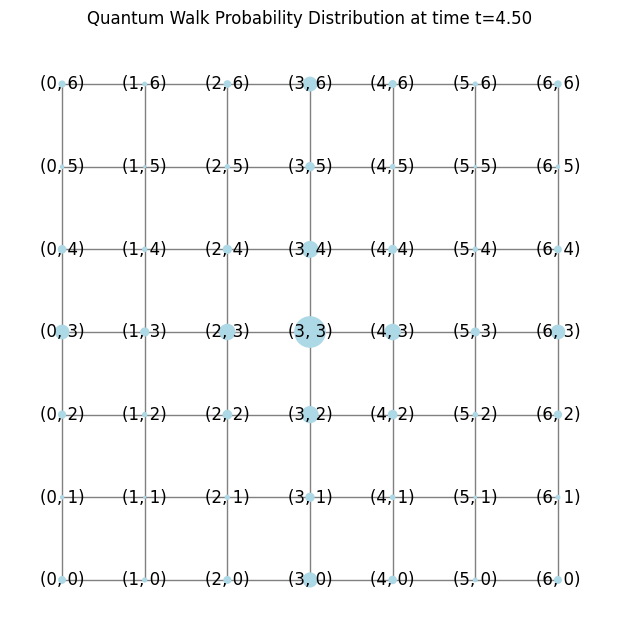

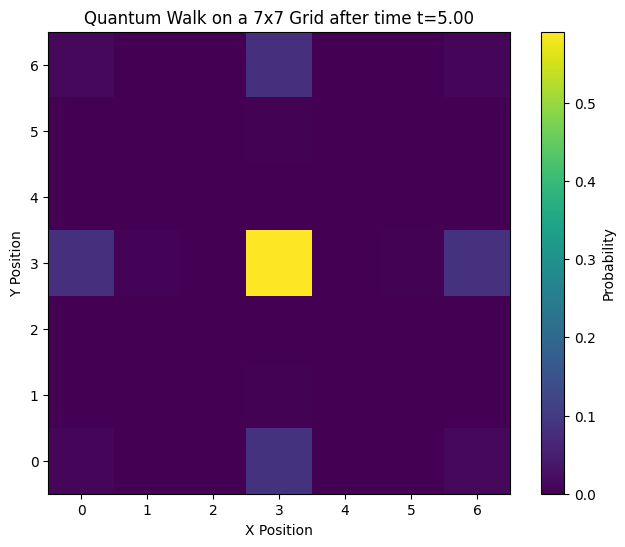

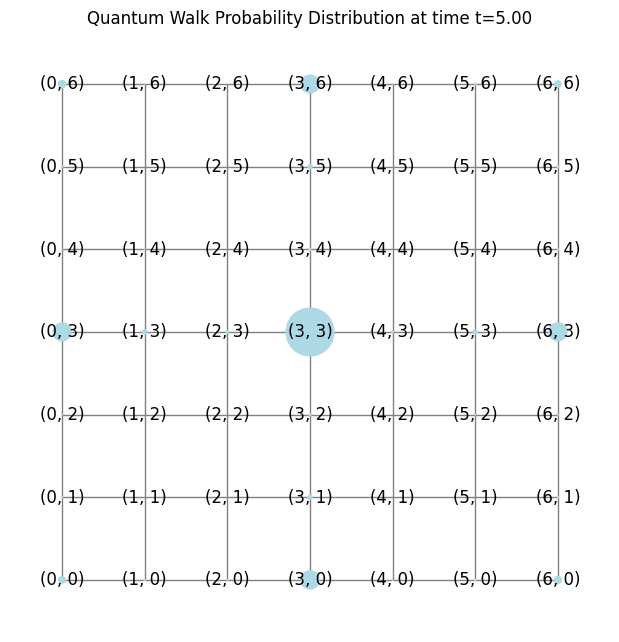

In [104]:
for t, node_probabilities in probability_distributions:
    plot_heatmap(node_probabilities, grid_size, t)
    plot_graph(G, pos, node_probabilities, t)   

For each time step $t$ in the quantum walk simulation, both the heatmap and graph-based visualizations are generated to track the evolution of the quantum walker's probability distribution across the grid. By observing the output for multiple time steps, we can identify how the walker's behavior changes dynamically over time, influenced by quantum interference and probabilistic spreading.

### Conclusion

This investigation provides a detailed mathematical and computational framework for simulating continuous-time quantum walks on a two-dimensional grid. The results elucidate the distinctive behaviors of quantum walks compared to classical random walks, emphasizing the role of quantum mechanics in dictating system dynamics [1]. In particular, phenomena such as **quantum interference** and **ballistic propagation** illustrate how quantum walkers spread across the grid differently from their classical counterparts [4]. This work lays the groundwork for further research into quantum algorithms and the simulation of more complex quantum systems [2].

Quantum walks form the foundation for various **quantum algorithms** with applications in areas such as **quantum search**, **quantum computing**, and **quantum information theory** [2], [4]. The methodologies described here can be extended to study more intricate quantum systems and streamline the **quantum algorithm development** [2], [3].

### References

[1] Y. Aharonov, L. Davidovich, and N. Zagury, "Quantum random walks," *Physical Review A*, vol. 48, no. 2, pp. 1687-1690, Aug. 1993.  
*This paper provides the foundational theoretical framework for quantum random walks, forming the basis for understanding the behaviors described in the introduction and section on quantum walk dynamics.*

[2] A. M. Childs, "Universal computation by quantum walk," *Physical Review Letters*, vol. 102, no. 18, p. 180501, May 2009.  
*This paper discusses quantum walk-based algorithms for universal computation and is relevant to the discussions in the conclusion and future research on quantum algorithms.*

[3] E. Farhi and S. Gutmann, "Quantum computation and decision trees," *Physical Review A*, vol. 58, no. 2, pp. 915-928, Aug. 1998.  
*This work is significant for introducing the concept of quantum walks in decision-making processes, which supports the algorithmic insights provided in the description of the simulation process.*

[4] J. Kempe, "Quantum random walks: An introductory overview," *Contemporary Physics*, vol. 44, no. 4, pp. 307-327, Jul. 2003.  
*This review gives a broad overview of quantum walks and their applications, aligning with the introductory explanation and the motivation for studying continuous-time quantum walks.*

[5] M. A. Nielsen and I. L. Chuang, *Quantum Computation and Quantum Information*, 10th ed. Cambridge, U.K.: Cambridge Univ. Press, 2010.  
*Nielsen and Chuang's textbook provides the necessary background in quantum computation and quantum mechanics, cited extensively throughout the description of the unitary operator and quantum walk simulations.*

